# Predicting from an HMM in split data

In certain cases, you may not want to use the built-in cross-validation (CV) functionality (covered in [*Predicting from an HMM*](./Prediction_tutorial.ipynb)). This may be because you are using a different scheme to define your folds, you want to train and test on separate populations (like patients and controls), or you are using training/testing as separate steps in another routine. This notebook shows how to use the toolbox's functionality to do this. 

If you are new to the (GL)HMM or are unsure how to fit the (GL)HMM, start with the tutorials [*Standard Gaussian Hidden Markov Model*](./GaussianHMM_example.ipynb) or [*Gaussian-Linear Hidden Markov Model*](./GLHMM_example.ipynb). 

Simulated data and pre-trained HMMs for this tutorial are available from the [OSF project page](https://osf.io/8qcyj/?view_only=119c38072a724e0091db5ba377935666).

**Note:** Due to rendering issues when viewing this notebook through github, internal links, like the table of contents, may not work correctly. To ensure that the notebook renders correctly, you can view it through [this link](https://nbviewer.org/github/vidaurre/glhmm/blob/main/docs/notebooks/Prediction_split.ipynb).

Authors: Christine Ahrends <christine.ahrends@cfin.au.dk>

## Outline
1. [Background](#background)
2. [Preparation](#preparation)
    * [Load and prepare data](#load-data)
    * [Train HMM](#train-hmm)
3. [Predicting individual traits from an HMM in split data](#prediction)
    * [Separate training and testing with deconfounding](#pred-wdeconf)
    * [Separate training and testing without deconfounding](#pred-wodeconf)
    * [Classifying from an HMM in split data](#classification)

## Background<a id="background"></a>

The different methods for predicting from an HMM are explained in detail in [*Predicting from an HMM*](./Prediction_tutorial.ipynb). We here only cover some considerations for separation between training and test set in this context.

When working with split data, it is important to consider on which levels of data processing this divide needs to be preserved. In our case, these levels are: preprocessing (not covered here), fitting the group-level HMM, feature normalisation/deconfounding, and model training. While training and test set are always kept separate for out-of-sample prediction for the last step, the other steps may differ. The gold-standard recommendation is to keep training and test data separate on every level to avoid leakage of information. However, in cases where the purpose is mainly to explain relations in the data (rather than generalising predictions to unseen data), the divide may be more important for the target variable. By default, the toolbox functions keep training and test set separate for feature normalisation/deconfounding, and model training. Whether the group-level HMM is fit only to the training dataset or to the concatenated data of training and test set is up to the user. 

We will here show an example of training the HMM only on the subjects we want to later use as training set to follow the gold-standard recommendation. Note though that when using the Fisher kernel, heterogeneity between the training and test set may bias the estimation, since individual subjects' features are here defined *in reference to the group-level model*, which test subjects would then not be part of (see [Ahrends, Woolrich, & Vidaurre, 2024](https://elifesciences.org/reviewed-preprints/95125) for an in-depth exploration of the effects).

## Preparation <a id="preparation"></a>
If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install glhmm```

**Import libraries**\
Let's start by importing the required libraries and modules.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glhmm import glhmm, preproc, prediction, io, graphics

### Load and prepare data <a id="load-data"></a>
Example data for this tutorial are available for download from the OSF. This notebook will fetch the relevant data from the OSF project page using the osfclient package. If you prefer, you can also directly download the files from the [OSF project page](https://osf.io/8qcyj/?view_only=119c38072a724e0091db5ba377935666) and skip the next two cells. 

In [2]:
# checks if osfclient is installed and otherwise installs it using pip install
# skip this if you have manually downloaded the data
import sys
import pip

def install(package):
    pip.main(['install', package])

try:
    import osfclient
except ImportError:
    print('osfclient is not installed, installing it now')
    install('osfclient')

In [3]:
! osf -p 8qcyj fetch Prediction/tc_forpred.csv ./data_prediction/tc_forpred.csv
! osf -p 8qcyj fetch Prediction/T_forpred.csv ./data_prediction/T_forpred.csv
! osf -p 8qcyj fetch Prediction/Y_forpred.csv ./data_prediction/Y_forpred.csv
! osf -p 8qcyj fetch Prediction/confounds_forpred.csv ./data_prediction/confounds_forpred.csv
! osf -p 8qcyj fetch Prediction/family_forpred.csv ./data_prediction/family_forpred.csv
! osf -p 8qcyj fetch Prediction/hmm_pred.pkl ./data_prediction/hmm_pred.pkl

100%|████████████████████████████████████| 434M/434M [00:26<00:00, 16.6Mbytes/s]
100%|██████████████████████████████████| 1.35k/1.35k [00:00<00:00, 6.15Mbytes/s]
100%|██████████████████████████████████| 1.82k/1.82k [00:00<00:00, 2.95Mbytes/s]
100%|██████████████████████████████████| 1.82k/1.82k [00:00<00:00, 7.89Mbytes/s]
100%|██████████████████████████████████| 30.0k/30.0k [00:00<00:00, 23.1Mbytes/s]
100%|████████████████████████████████████| 408k/408k [00:00<00:00, 7.95Mbytes/s]


This will create a folder called **data_prediction**. Load the following files from the folder:
* data: simulated resting-state-like fMRI timeseries: 4800 timepoints from 100 subjects in a parcellation with 50 ROIs
* behav: simulated behavioural items from 100 subjects
* T_t: indices for beginning and start of each subject's scanning session
* twins: matrix indicating family structure (subjects x subjects), zeros for unrelated subjects and positive values for related subjects (diagonal will be ignored)
* confounds: confounding variable for 100 subjects

In [4]:
# load data from csv files and convert to numpy arrays
data = pd.read_csv('./data_prediction/tc_forpred.csv', header=None).to_numpy()
T_t = pd.read_csv('./data_prediction/T_forpred.csv', header=None).to_numpy()
behav = np.squeeze(pd.read_csv('./data_prediction/Y_forpred.csv', header=None).to_numpy())
twins = pd.read_csv('./data_prediction/family_forpred.csv', header=None).to_numpy()
confounds = np.squeeze(pd.read_csv('./data_prediction/confounds_forpred.csv', header=None).to_numpy())

# check that dimensions of input files are correct:
print(data.shape) # data should be (n_subjects*n_timepoints, n_parcels)
print(behav.shape) # behav should be (n_subjects, n_variables)
print(T_t.shape) # T_t should be (n_subjects, 2)
print(twins.shape) # twins should be (n_subjects, n_subjects)
print(confounds.shape) # confounds should be (n_subjects, n_confounds) or (n_subjects,)

(480000, 50)
(100,)
(100, 2)
(100, 100)
(100,)


Standardise timeseries for all following computations. This is an important step, especially when looking at differences between individuals, to make sure that predictions are not driven by measurement noise.

In [5]:
data_preproc,_ = preproc.preprocess_data(data, T_t)
del data # we will only use the standardised version of the time series going forward

### Split dataset into training and test set
To illustrate a split dataset, we will here simply use the first 50 subjects as training set and the next 50 subjects as a test set. In reality, these may be obtained from splitting functions, e.g. sklearn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split), or come from separate populations or datasets.

In [ ]:
train_indices = np.arange(50)
test_indices = np.arange(50, 100)

# separate time series for training and test set
T_train = T_t[train_indices,:]
T_test = T_t[test_indices,:]
# to get time series indices, use aux functions:
ts_train = glhmm.auxiliary.slice_matrix(data_preproc, T_train)
ts_test = glhmm.auxiliary.slice_matrix(data_preproc, T_test)

# separate target variables for training and test set
target_train = behav[train_indices]
target_test = behav[test_indices]

# separate confounds for training and test set
confounds_train = confounds[train_indices]
confounds_test = confounds[test_indices]

# separate group structure for training and test set 
twins_train = twins[0:50, 0:50]
twins_test = twins[50:100, 50:100]

# for this purpose we will not need the full dataset anymore, so delete it to save memory:
del data_preproc, behav, confounds, twins, T_t

### Train HMM <a id="train-hmm"></a>

Train the HMM using only subjects from the training set:

In [31]:
%%capture
np.random.seed(123)
hmm = glhmm.glhmm(model_beta='no', K=6, covtype='full')
hmm.train(X=None, Y=ts_train, indices=T_train)

Alternatively, you can load the pre-trained HMM (which was fitted to all subjects).

In [34]:
# hmm = io.load_hmm('./example_data/hmm_hcp_preproc.pkl')

Check the parameters. We will use these to construct kernels, so it's a good idea to make sure they look reasonable before proceeding. In this case, we have simulated data where one of the states' mean is correlated with the target variable, with the addition of noise. The state covariances are kept the same for simplicity in this example. Note that it is not necessary for the true features of interest to be the state means but they can be any of the HMM parameters.

In [32]:
K = hmm.hyperparameters["K"] # the number of states
q = ts_train.shape[1] # the number of parcels/channels
init_stateP = hmm.Pi # the initial state probabilities
TP = np.zeros(shape=(K, K))
TP = hmm.P # the transition probability matrix
state_means = np.zeros(shape=(q, K))
state_means = hmm.get_means() # the state means in the shape (no. features, no. states)
state_FC = np.zeros(shape=(q, q, K))
for k in range(K):
    state_FC[:,:,k] = hmm.get_covariance_matrix(k=k)

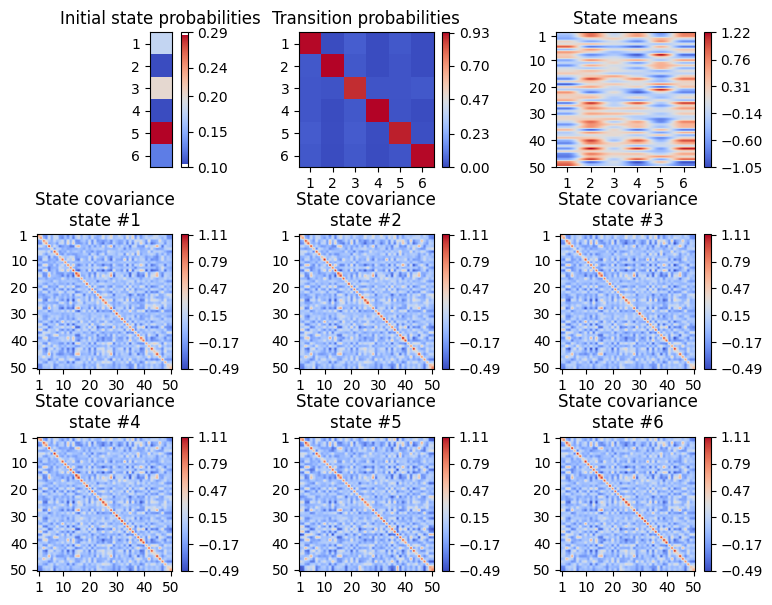

In [33]:
graphics.plot_state_prob_and_covariance(init_stateP, TP, state_means, 
                                        state_FC, cmap='coolwarm')

## Predicting individual traits from an HMM in split data <a id="prediction"></a>
When separately training and testing the predictive models on an HMM, you can use the functions `train_pred` and `test_pred` from the `prediction` module. The main difference to the full function with built-in CV (`predict_phenotype`) is that you need to assign additional outputs from the training step and pass them on to the test function. By default, the functions will standardise the features (when using the summary metrics approach) or center the kernel (when using the Fisher kernel approach). To keep the separation between training and test set, we fit these estimators only in the training set and then pass them on to the test function. The additional outputs depend on whether or not your routine involves deconfounding:

### Separate training and testing with deconfounding <a id="pred-wdeconf"></a>
When using deconfounding, we also estimate the parameters for deconfounding only on the training set. We need to assign them as output to the function `train_pred` and later pass them to `test_pred`. We here use a similar routine to the one in [*Predicting from an HMM*](./Prediction_tutorial.ipynb), so you can compare the syntax. 

We first specify the options and then train the predictive model using only the training set:

In [34]:
np.random.seed(123)

options = {}
# general options:
options['optim_hyperparam'] = 'GridSearchCV'
options['nfolds'] = 10 # number of folds for inner CV loops
options['group_structure'] = twins_train # group structure that inner CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
# when not using group/family structure, simply don't specify this option
options['confounds'] = confounds_train # confounding variables (here sex and head motion)
# when not using confounds, simply don't specify this option

# Fisher kernel options:
options['shape'] = 'linear'
options['incl_Mu'] = True # include state means
options['incl_Sigma'] = True # include state covariances
# the initial state probabilities and the transition probabilities
# are used by default, but can be excluded by setting options['incl_Pi']
# and options['incl_P'], respectively, to False

# train the model and assign outputs:
# model_train: the trained model
# scaler_x: the feature_standardiser or kernel_centerer
# CinterceptY, CbetaY: the estimates of the deconfounding
model_train, scaler_x, CinterceptY, CbetaY, behavD = prediction.train_pred(hmm, ts_train, target_train, T_train, predictor='Fisherkernel', estimator='KernelRidge', options=options)

When using the Fisher kernel, you need to pass the time series, session indices, target variable, and confounds for **both the training and test data** to `test_pred`, and then specify the indices of the examples that were used for training. This is necessary in order to construct the kernel (similarity between the examples in the test set to each of the examples in the training set)

In [35]:
ts_all = np.r_[ts_train, ts_test]
T_all = np.r_[T_train, T_test]
target_all = np.r_[target_train, target_test]
confounds_all = np.r_[confounds_train, confounds_test]

In [36]:
options = {}
options['confounds'] = confounds_all
results = prediction.test_pred(hmm, ts_all, T_all, model_train, scaler_x, CbetaY=CbetaY, CinterceptY=CinterceptY, behav=target_all, train_indices=train_indices, options=options)

In [37]:
print(f'The accuracy of predicting Y in the test set using the Fisher kernel approach is rho={format(results["corr_deconf"], ".2f")}')

The accuracy of predicting Y in the test set using the Fisher kernel approach is rho=0.78


We can interrogate the results by looking at the deconfounded version of the predicted variable in the `results` dict:

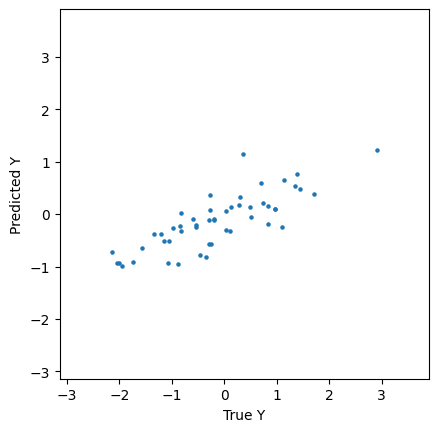

In [38]:
plt.scatter(target_test, results['behav_predD'], s=5, color='tab:blue')
minval = min((min(target_test), min(results['behav_predD'])))
maxval = max((max(target_test), max(results['behav_predD'])))
plt.xlim((minval-1),(maxval+1))
plt.ylim((minval-1),(maxval+1))
plt.gca().set_xlabel('True Y')
plt.gca().set_ylabel('Predicted Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In contrast, when you use summary metrics for the prediction, while the syntax for training the model is the same as above, you should only pass the test set to the `test_pred` function. You may need to adjust your session indices if you have split the time series, as we did above. In our case, that means we need to reset the first index of the session indices of the test set to 0:

In [39]:
T_test_adj = T_test-T_train[-1,1]

In [40]:
# train the predictive model using summary metrics
np.random.seed(123)
options = {}
# general options:
options['optim_hyperparam'] = 'GridSearchCV'
options['nfolds'] = 10 # number of folds for inner CV loops
options['group_structure'] = twins_train # group structure that inner CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
# when not using group/family structure, simply don't specify this option
options['confounds'] = confounds_train
model_train_summ, scaler_x, CinterceptY, CbetaY, behavD = prediction.train_pred(hmm, ts_train, target_train, T_train, predictor='summary_metrics', options=options)

# test the model only on the test set:
options = {}
options['confounds'] = confounds_test
results = prediction.test_pred(hmm, ts_test, T_test_adj, model_train_summ, scaler_x, predictor='summary_metrics', CbetaY=CbetaY, CinterceptY=CinterceptY, behav=target_test, train_indices=None, options=options)

In [41]:
print(f'The accuracy of predicting Y in the test set using the summary metrics approach is rho={format(results["corr_deconf"], ".2f")}')

The accuracy of predicting Y in the test set using the summary metrics approach is rho=0.62


### Separate training and testing without deconfounding <a id="pred-wodeconf"></a>

When not using deconfounding, the functions will by default standardise the target variable. In this case, you will need to assign the estimator `scaler_y` as output (instead of the deconfounding estimates `CinterceptY` and `CbetaY`).

In [42]:
# train the model without deconfounding
# (remove options['confounds'] or set them to None)
np.random.seed(123)
options = {}
# general options:
options['optim_hyperparam'] = 'GridSearchCV'
options['nfolds'] = 10 # number of folds for inner & outer CV loops
options['group_structure'] = twins_train # group structure that CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
# Fisher kernel options:
options['shape'] = 'linear'
options['incl_Mu'] = True # include state means
options['incl_Sigma'] = True # include state covariances
model_train, scaler_x, scaler_y = prediction.train_pred(hmm, ts_train, target_train, T_train, predictor='Fisherkernel', estimator='KernelRidge', options=options)

# test the model: pass the model, scaler_x and scaler_y on to test_pred
# remember that we here need to feed both the training and test data as input since we are using the Fisher kernel

options = {}
results = prediction.test_pred(hmm, ts_all, T_all, model_train, scaler_x, scaler_y=scaler_y, behav=target_all, train_indices=train_indices, options=options)

In [43]:
print(f'The accuracy of predicting Y in the test set using the Fisher kernel approach without deconfounding is rho={format(results["corr"], ".2f")}')

The accuracy of predicting Y in the test set using the Fisher kernel approach without deconfounding is rho=0.83


We can do the same with the summary metrics approach. Remember that we here only pass the test set on to `test_pred`:

In [44]:
# when not using deconfounding, leave out options['confounds'] and pass the scaler_y from train_pred to test_pred
# train the predictive model using summary metrics
np.random.seed(123)
options = {}
# general options:
options['optim_hyperparam'] = 'GridSearchCV'
options['nfolds'] = 10 # number of folds for inner CV loops
options['group_structure'] = twins_train # group structure that inner CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
# when not using group/family structure, simply don't specify this option
model_train_summ, scaler_x, scaler_y = prediction.train_pred(hmm, ts_train, target_train, T_train, predictor='summary_metrics', options=options)

# test the model only on the test set:
options = {}
results = prediction.test_pred(hmm, ts_test, T_test_adj, model_train_summ, scaler_x, predictor='summary_metrics', scaler_y=scaler_y, behav=target_test, train_indices=None, options=options)

In [45]:
print(f'The accuracy of predicting Y in the test set using the summary metrics approach without deconfounding is rho={format(results["corr"], ".2f")}')

The accuracy of predicting Y in the test set using the summary metrics approach without deconfounding is rho=0.61


### Classifying from an HMM in split data <a id="classification"></a>

Analogous to `train_pred`, and `test_pred`, the functions `train_classif` and `test_classif` allow classifying from an HMM. We have simulated timecourses for two groups of subjects, where the first 50 subjects belong to group 1 and the second 50 subjects belong to group 2. As in the regression problem above, we have simulated the effect to be in one of the state means (but making sure that the difference is small enough that the state does not occur exclusively in one of the groups). As opposed to the simulated data above, there is no additional between-subject noise, so the group difference should be fairly obvious. 


In [46]:
! osf -p 8qcyj fetch Prediction/tc_forclass.csv ./data_prediction/tc_forclass.csv
! osf -p 8qcyj fetch Prediction/T_forpred.csv ./data_prediction/T_forpred.csv
! osf -p 8qcyj fetch Prediction/Y_forpred.csv ./data_prediction/Y_forpred.csv
! osf -p 8qcyj fetch Prediction/confounds_forpred.csv ./data_prediction/confounds_forpred.csv
! osf -p 8qcyj fetch Prediction/family_forpred.csv ./data_prediction/family_forpred.csv
! osf -p 8qcyj fetch Prediction/hmm_class.pkl ./data_prediction/hmm_class.pkl

100%|████████████████████████████████████| 109M/109M [00:06<00:00, 16.3Mbytes/s]
usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./data_prediction/T_forpred.csv already exists, not overwriting.
usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./data_prediction/Y_forpred.csv already exists, not overwriting.
usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./data_prediction/confounds_forpred.csv already exists, not overwriting.
usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./data_prediction/family_forpred.csv already exists, not overwriting.
100%|████████████████████████████████████| 408k/408k [00:00<00:00, 5.60Mbytes/s]


In [70]:
data_c = pd.read_csv('./data_prediction/tc_forclass.csv', header=None).to_numpy()
twins = pd.read_csv('./data_prediction/family_forpred.csv', header=None).to_numpy()
group = np.ones(100)
group[50:100] = 2 # create classes: the first 50 subjects are group 1, the second 50 subjects are group 2
T = np.repeat(1200,100) # we have simulated 100 subjects with 1200 timepoints each
T_tc = glhmm.auxiliary.make_indices_from_T(T)

In [71]:
data_c_preproc,_ = preproc.preprocess_data(data_c, T_tc)
del data_c

Since we now have a structure where the first 50 subjects are group 1 and the second 50 subjects are group 2 (i.e., the classes we are trying to recover), we will use a different split to above:

In [72]:
train_indices = np.r_[np.arange(30), np.arange(50, 80)]
test_indices = np.r_[np.arange(30, 50), np.arange(80, 100)]

# separate time series for training and test set
T_train = T_tc[train_indices,:]
T_test = T_tc[test_indices,:]
# to get time series indices, use aux functions:
ts_train = glhmm.auxiliary.slice_matrix(data_c_preproc, T_train)
ts_test = glhmm.auxiliary.slice_matrix(data_c_preproc, T_test)

# separate target variables for training and test set
target_train = group[train_indices]
target_test = group[test_indices]

# separate group structure for training and test set 
twins_train = twins[train_indices.reshape(-1,1), train_indices]
twins_test = twins[test_indices.reshape(-1,1), test_indices]

# for this purpose we will not need the full dataset anymore, so delete it to save memory:
# del data_c_preproc, group, twins, T_tc

In [74]:
T_train_adj = T_tc[np.arange(60),:]

As before, we can either train a separate HMM only on the training subjects or load the pre-trained HMM (fit to all subjects)

In [75]:
%%capture
np.random.seed(123)
T_train_adj = T_tc[np.arange(60),:] # adjust T_train so timepoints are in reference to the training set (rather than the full dataset)
hmm_c = glhmm.glhmm(model_beta='no', K=6, covtype='full')
hmm_c.train(X=None, Y=ts_train, indices=T_train_adj)

In [ ]:
# to load pre-trained HMM instead:
# hmm_c = io.load_hmm('./data_prediction/hmm_class.pkl')

To train a classifier that we want to test on a separate test set later, we need to specify the options for the kernel and classification, and then save both the model and the scaler (feature normaliser or kernel centerer) as output. Estimating the scaler only on the training set and then passing it on at the testing stage avoids leakage of information between the training and test set.

In [78]:
np.random.seed(123)

options = {}
# general options:
options['nfolds'] = 10 # number of folds for inner & outer CV loops
options['group_structure'] = twins_train # group structure that CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
# optional outputs:
options['return_scores'] = True
options['return_models'] = True
options['return_hyperparams'] = True
options['return_prob'] = True # for classification, you can optionally also return the probabilities for each class, but note that this will take longer
# Fisher kernel options:
options['shape'] = 'linear'
options['incl_Mu'] = True # include state means
options['incl_Sigma'] = True # include state covariances

# use HMM trained/loaded above and standardised timeseries to classify sex using Fisher kernel method:
classif_train, scaler_x = prediction.train_classif(hmm_c, ts_train, target_train, T_train_adj, predictor='Fisherkernel', estimator='SVM', options=options)

As explained above, when using the Fisher kernel, you need to pass the time series, session indices, target variable, and confounds for **both the training and test data** to `test_classif`, and then specify the indices of the examples that were used for training. This is necessary in order to construct the kernel (similarity between the examples in the test set to each of the examples in the training set). When using the summary metrics approach, you can pass only the test set to `test_classif` and set `train_indices` to `None`.

In [79]:
ts_all = np.r_[ts_train, ts_test]
T_all = np.r_[T_train, T_test]
target_all = np.r_[target_train, target_test]

We can then test our classifier in the test set by providing the trained model and scaler:

In [81]:
options = {}
results_classif = prediction.test_classif(hmm_c, ts_all, T_all, classif_train, scaler_x, behav=target_all, train_indices=train_indices, options=options)

In [85]:
print(f'The accuracy of classifying Y in the test set using the Fisher kernel approach is {results_classif["acc"]}')

The accuracy of classifying Y in the test set using the Fisher kernel approach is 0.8
